# Определение возможного согласия на покупку оборудования клиентом

# Модель, прогнозирующая согласие клиента

**Заказчик:** телеком-компания R1

**Входные данные:** информация с характеристиками клиентов; данные изначально разделены на обучающий и тестовый наборы.

**Цель проекта:** разработать модель, предсказывающую вероятность согласия клиента. Если модель покажет, что вероятность высокая, то клиенту позвонят с предложением. Лучшая модель будет опробована и конверсия доведена до разработчика. 

**Задачи проекта:**

- провести исследовательский анализ данных;
- выбрать признаки для обучения моделей;
- обучить разные модели и оценить их качество кросс-валидацией;
- выбрать лучшую модель и проверить ее на тестовой выборке;
- сравнить эффект, который принесет выбранная модель;
- дать рекомендации по дальнейшему развитию данного проекта.

## Intro

**Пояснения к оформлению**

Основные таблицы с данными обозначаются как **"data"**.  

Рабочие таблицы с данными обозначаются как **"df"**.  

Временные таблицы с данными обозначаются как **"tmp"**.  


## Начальная подготовка

In [119]:
!pip install pyarrow
!pip install fastparquet

     --------------------------------------- 24.4/24.4 MB 36.4 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     -------------------------------------- 715.0/715.0 kB 5.0 MB/s eta 0:00:00
     ---------------------------------------- 1.3/1.3 MB 17.0 MB/s eta 0:00:00
     --------------------------------------- 10.8/10.8 MB 32.7 MB/s eta 0:00:00
     --------------------------------------- 15.8/15.8 MB 40.9 MB/s eta 0:00:00
     ---------------------------------------- 341.8/341.8 kB ? eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5


ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'D:\\anaconda3\\Lib\\site-packages\\~umpy\\core\\_multiarray_tests.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [120]:
import pandas as pd
import numpy as np

import os
import json
import warnings
from datetime import date
import re

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import plotly.graph_objects as go
import plotly.io as pio

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

#from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score
from sklearn.inspection import permutation_importance

#import optuna


### Константы

In [57]:
RANDOM_STATE = RS = 12345 # константа для random_state
CR = '\n'                 # новая строка
N_TRIALS = 200            # количество попыток для Optuna
TIMEOUT = 300             # максимальный порог времени для Optuna
SCORING = 'f1'            # основная метрика
LOCAL_PATH = 'D:/hackathonR1/'

### Вспомогательные функции 

In [37]:
def df_name(df):
    """
    определение имени таблицы
    """
    return [name for name in globals() if globals()[name] is df][0]

In [ ]:
# выделение в тексте
class f:
    BOLD = "\033[1m"
    ITALIC = "\033[3m"
    END = "\033[0m"

In [38]:
def basic_info(df: pd.DataFrame, sample_type='sample', samples=5, describe='all'):
    """
    первичная информация о таблице: info(), sample()/head()/tail(), describe()
    """
    
    # заголовок (имя исследуемого датафрейма)
    
    print('датафрейм - ', df_name)


    # метод info()
    
    print('\n\n--- метод info() ---\n')
    print(df.info())

    
    # несколько случайных записей
    
    print(f'\n\n--- метод {sample_type}({samples}) ---')
    
    if sample_type == 'sample':
        display(df.sample(samples))
    elif sample_type == 'head':
        display(df.head(samples))
    elif sample_type == 'tail':
        display(df.tail(samples))
    else:
        print(f'{sample_type} – недопустимое значение параметра "sample_type" ')
    
    
    # метод describe()
    
    print(f'\n\n--- метод describe({describe}) ---')
    
    if describe=='all' or describe=='numeric':
        try:
            display(df.describe(include=np.number))
        except ValueError:
            pass

    if describe=='all' or describe=='categorical':
        try:
            display(df.describe(exclude=np.number).T)
        except ValueError:
            pass
    
    if describe not in ['numeric','categorical','all']:
        print(f'{describe} – недопустимое значение параметра "describe" ')

### Оформление

In [39]:
# выделение в тексте
class f:
    BOLD = "\033[1m"
    ITALIC = "\033[3m"
    END = "\033[0m"

In [40]:
# оформление графиков по-умолчанию

# Matplotlib, Seaborn
sns.set_style('whitegrid', {'axes.facecolor': '0.98', 'grid.color': '0.9', 'axes.edgecolor': '1.0'})
plot_dpi = 150                                        # dpi для рендеринга графиков

# Plotly Graph_Objects
pio.templates['my_theme'] = go.layout.Template(
                                               layout_autosize=True,
                                               # width=900,
                                               layout_height=200,
                                               layout_legend_orientation="h",
                                               layout_margin=dict(t=40, b=40),         # (l=0, r=0, b=0, t=0, pad=0)
                                               layout_template='seaborn',
                                              )
pio.templates.default = 'my_theme'

# цвета, цветовые схемы
my_cmap = LinearSegmentedColormap.from_list('', ['steelblue', 'aliceblue', 'steelblue'])

In [41]:
# оформление Pandas
pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.3f}'.format
# pd.options.display.colheader_justify = 'left'

In [43]:
# оформление Optuna
#optuna.logging.set_verbosity(optuna.logging.WARNING)  # отключение вывода логов при работе optuna

In [44]:
# оформление — скрытие предупреждений
warnings.filterwarnings('ignore')

## Входные данные

### Чтение и проверка входных данных

In [46]:
#data = custom_read_csv('datasets/hotel_train.csv')  # данные для обучения
#data_test = custom_read_csv('datasets/hotel_test.csv')  # данные для проверки

In [58]:
data_descr = pd.read_json(LOCAL_PATH+'features_types.json', orient='index').reset_index()

In [49]:
basic_info(data_descr)

датафрейм -  <function df_name at 0x000001B4604DE0D0>


--- метод info() ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2776 entries, 0 to 2775
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   2776 non-null   object
 1   0       2776 non-null   object
dtypes: object(2)
memory usage: 43.5+ KB
None


--- метод sample(5) ---


,index,0
659,markers_678_1_cnt,numeric
1536,spas_symptoms_agr_66_6_std,numeric
1947,issues_144_6_avg,numeric
515,markers_531_1_cnt,numeric
769,markers_791_1_cnt,numeric




--- метод describe(all) ---


,count,unique,top,freq
index,2776,2776,markers_0_1_cnt,1
0,2776,3,numeric,2607


In [50]:
data_descr.head()

,index,0
0,markers_0_1_cnt,numeric
1,markers_1_1_cnt,numeric
2,markers_2_1_cnt,numeric
3,markers_3_1_cnt,numeric
4,markers_4_1_cnt,numeric


In [51]:
data_descr.columns

Index(['index', 0], dtype='object')

In [52]:
data_descr[0].unique()

array(['numeric', 'categorical_str', 'categorical_int'], dtype=object)

In [53]:
data_descr[data_descr[0] == 'categorical_int']

,index,0
805,communication_availability_0_1_flg,categorical_int
837,communication_availability_1_1_ctg,categorical_int
839,communication_availability_2_1_flg,categorical_int
842,user_lifetime_1_1_flg,categorical_int
844,communication_availability_3_1_flg,categorical_int
847,materials_details_5_1_flg,categorical_int
849,materials_details_7_1_flg,categorical_int
850,materials_details_8_1_flg,categorical_int
974,communication_availability_4_1_flg,categorical_int
975,communication_availability_5_1_flg,categorical_int


In [54]:
data_descr[data_descr[0] == 'categorical_str'].count()

index    31
0        31
dtype: int64

In [55]:
data_descr[data_descr[0] == 'categorical_int'].count()

index    138
0        138
dtype: int64

In [56]:
data_descr[data_descr[0] == 'numeric'].count()

index    2607
0        2607
dtype: int64

In [59]:
data_descr.to_csv (LOCAL_PATH +'data_descr.csv', index= False )

In [70]:
data_descr.head()

,index,0
0,markers_0_1_cnt,numeric
1,markers_1_1_cnt,numeric
2,markers_2_1_cnt,numeric
3,markers_3_1_cnt,numeric
4,markers_4_1_cnt,numeric


Итак, у нас 3 неодинаковых по количеству типа признаков. 31 категориальный с описанием, 138 категориальных биномиальных. И больше двух с половиной тысяч числовых.

Числовые данные неплохо группируются по типам:
1. Какого рода информацию они кодируют:
markers
spas_symptoms_agr
payments_details
user_devices
materials_details
arpu
balance_details
charges_details
tariff_plans
plan_costs
charges_details
vas_details
smarttv_age
spas_symptoms_int
area
traffic_details
traffic_details
movix_channels
user_lifetime
info_house
deact_react
issues
online_cinema
save_team_answers
movix_app_visits

2. Какой тип данных (среднее, сумма и т.д.)
На конце
dex
cnt
std
sum
avg
ctg
flg
pct
_dt
num
ean
max
_id
art
min

    

Зададим уникальные группы начала файла

In [60]:
col_start = ['markers_', 'spas_symptoms', 'materials_details', 'communication_availability', 'payments_details', 'user_devices',
             'user_lifetime', 'arpu_', 'balance_details', 'charges_details', 'tariff_plans', 'plan_costs', 'vas_details', 
             'social_dem', 'smarttv_age', 'area_', 'user_active', 'traffic_details', 'scheme_types', 'movix_channels',
             'deact_react', 'info_house', 'exist_tariff', 'issues_', 'online_cinema', 'cities_', 'save_team', 'migrant_', 
             'movix_app', 'basic_info', 'type_av', 'agreement_type', 'autopay_', 'campaigns_', 'overdue_payments', 'domru_site']

In [61]:
col_end = ['_dex', '_cnt', '_std', '_sum', '_avg', '_ctg', '_flg', '_pct', '_dt', '_num', '_ean', '_max', '_id', '_art', '_min']

In [ ]:
column_list = []

In [105]:
def filter_by_pattern(df, column_name, pattern):
  return df[df[column_name].apply(lambda x: bool(re.search(pattern+'.*', x)))]

In [108]:
pattern = col_start[2]
pattern

'materials_details'

In [127]:
column_list = filter_by_pattern(data_descr, 'index', pattern)

column_list = pd.Series(column_list['index']).tolist()
column_list

['materials_details_0_1_ctg',
 'materials_details_1_1_ctg',
 'materials_details_2_1_cnt',
 'materials_details_3_1_dt',
 'materials_details_4_1_dt',
 'materials_details_5_1_flg',
 'materials_details_6_1_num',
 'materials_details_7_1_flg',
 'materials_details_8_1_flg',
 'materials_details_9_1_flg',
 'materials_details_10_1_flg',
 'materials_details_11_1_flg',
 'materials_details_12_1_flg',
 'materials_details_13_1_ctg',
 'materials_details_14_1_ctg',
 'materials_details_15_1_ctg',
 'materials_details_16_1_ctg',
 'materials_details_17_1_cnt',
 'materials_details_18_1_dt',
 'materials_details_19_1_dt',
 'materials_details_20_1_flg',
 'materials_details_21_1_num',
 'materials_details_22_1_flg',
 'materials_details_23_1_flg',
 'materials_details_24_1_cnt',
 'materials_details_25_1_cnt']

In [129]:

def read_columns_from_list(column_list, file_name):
    df = pd.read_parquet(columns=column_list, path = LOCAL_PATH+file_name) 
    return df 


In [130]:
# Начинаем открывать
parquet_name = 'dataset_train.parquet'
part_df_2 = read_columns_from_list(column_list, parquet_name)

In [131]:
part_df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702086 entries, 0 to 702085
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   materials_details_0_1_ctg   702086 non-null  int64  
 1   materials_details_1_1_ctg   702086 non-null  int64  
 2   materials_details_2_1_cnt   121665 non-null  float64
 3   materials_details_3_1_dt    61361 non-null   float64
 4   materials_details_4_1_dt    61361 non-null   float64
 5   materials_details_5_1_flg   702086 non-null  int8   
 6   materials_details_6_1_num   61361 non-null   float64
 7   materials_details_7_1_flg   702086 non-null  int8   
 8   materials_details_8_1_flg   702086 non-null  int8   
 9   materials_details_9_1_flg   702086 non-null  int32  
 10  materials_details_10_1_flg  702086 non-null  int32  
 11  materials_details_11_1_flg  702086 non-null  int32  
 12  materials_details_12_1_flg  702086 non-null  int32  
 13  materials_deta

In [132]:
part_df_2.head()

,materials_details_0_1_ctg,materials_details_1_1_ctg,materials_details_2_1_cnt,materials_details_3_1_dt,materials_details_4_1_dt,materials_details_5_1_flg,materials_details_6_1_num,materials_details_7_1_flg,materials_details_8_1_flg,materials_details_9_1_flg,materials_details_10_1_flg,materials_details_11_1_flg,materials_details_12_1_flg,materials_details_13_1_ctg,materials_details_14_1_ctg,materials_details_15_1_ctg,materials_details_16_1_ctg,materials_details_17_1_cnt,materials_details_18_1_dt,materials_details_19_1_dt,materials_details_20_1_flg,materials_details_21_1_num,materials_details_22_1_flg,materials_details_23_1_flg,materials_details_24_1_cnt,materials_details_25_1_cnt
0,1,1,NaN,NaN,NaN,-1,NaN,-1,-1,-1,-1,-1,-1,1,0,0,NaN,NaN,NaN,NaN,-1,NaN,-1,-1,NaN,NaN
1,1,1,NaN,NaN,NaN,-1,NaN,-1,-1,-1,-1,-1,-1,1,0,0,NaN,NaN,NaN,NaN,-1,NaN,-1,-1,NaN,NaN
2,1,1,NaN,NaN,NaN,-1,NaN,-1,-1,-1,-1,-1,-1,1,0,0,NaN,NaN,NaN,NaN,-1,NaN,-1,-1,NaN,NaN
3,1,1,NaN,NaN,NaN,-1,NaN,-1,-1,-1,-1,-1,-1,1,0,0,NaN,NaN,NaN,NaN,-1,NaN,-1,-1,NaN,NaN
4,1,1,NaN,NaN,NaN,-1,NaN,-1,-1,-1,-1,-1,-1,1,0,0,NaN,NaN,NaN,NaN,-1,NaN,-1,-1,NaN,NaN


In [133]:
part_df_2.describe()

,materials_details_0_1_ctg,materials_details_1_1_ctg,materials_details_2_1_cnt,materials_details_3_1_dt,materials_details_4_1_dt,materials_details_5_1_flg,materials_details_6_1_num,materials_details_7_1_flg,materials_details_8_1_flg,materials_details_9_1_flg,materials_details_10_1_flg,materials_details_11_1_flg,materials_details_12_1_flg,materials_details_13_1_ctg,materials_details_14_1_ctg,materials_details_15_1_ctg,materials_details_16_1_ctg,materials_details_17_1_cnt,materials_details_18_1_dt,materials_details_19_1_dt,materials_details_20_1_flg,materials_details_21_1_num,materials_details_22_1_flg,materials_details_23_1_flg,materials_details_24_1_cnt,materials_details_25_1_cnt
count,702086.000,702086.000,121665.000,61361.000,61361.000,702086.000,61361.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,702086.000,59761.000,121665.000,52187.000,52187.000,702086.000,52187.000,702086.000,702086.000,121665.000,121665.000
mean,6.786,1.393,0.099,-0.079,-0.082,-0.781,-0.079,-0.794,-0.816,-0.809,-0.752,-0.812,-0.739,7.747,25.870,527.167,0.067,-0.088,-0.049,-0.050,-0.782,-0.048,-0.802,-0.819,0.009,-0.002
std,33.646,5.650,1.017,0.977,0.974,0.512,0.977,0.479,0.413,0.437,0.579,0.426,0.606,32.882,66.034,1266.124,0.997,0.989,0.969,0.969,0.510,0.969,0.456,0.404,1.017,0.996
min,0.000,0.000,-0.870,-2.110,-2.103,-1.000,-2.110,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,0.000,0.000,0.000,-1.542,-0.865,-1.871,-1.824,-1.000,-1.870,-1.000,-1.000,-0.288,-0.326
25%,1.000,1.000,-0.870,-0.704,-0.728,-1.000,-0.703,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,1.000,0.000,0.000,-1.046,-0.865,-0.834,-0.818,-1.000,-0.833,-1.000,-1.000,-0.288,-0.326
50%,1.000,1.000,0.953,0.100,0.106,-1.000,0.100,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,1.000,0.000,0.000,0.608,-0.865,-0.154,-0.177,-1.000,-0.152,-1.000,-1.000,-0.288,-0.326
75%,1.000,1.000,0.953,0.600,0.625,-1.000,0.601,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,1.000,0.000,0.000,0.608,0.775,0.755,0.724,-1.000,0.757,-1.000,-1.000,-0.288,-0.326
max,303.000,86.000,10.069,6.054,6.177,1.000,6.056,1.000,1.000,1.000,1.000,1.000,1.000,248.000,317.000,4998.000,3.090,31.939,8.356,8.542,1.000,8.355,1.000,1.000,13.021,16.681


In [134]:
part_df_2['materials_details_7_1_flg'].value_counts()

-1    580421
 0     98654
 1     23011
Name: materials_details_7_1_flg, dtype: int64

In [135]:
part_df_2['materials_details_9_1_flg'].value_counts()
   

-1    580421
 0    108887
 1     12778
Name: materials_details_9_1_flg, dtype: int64

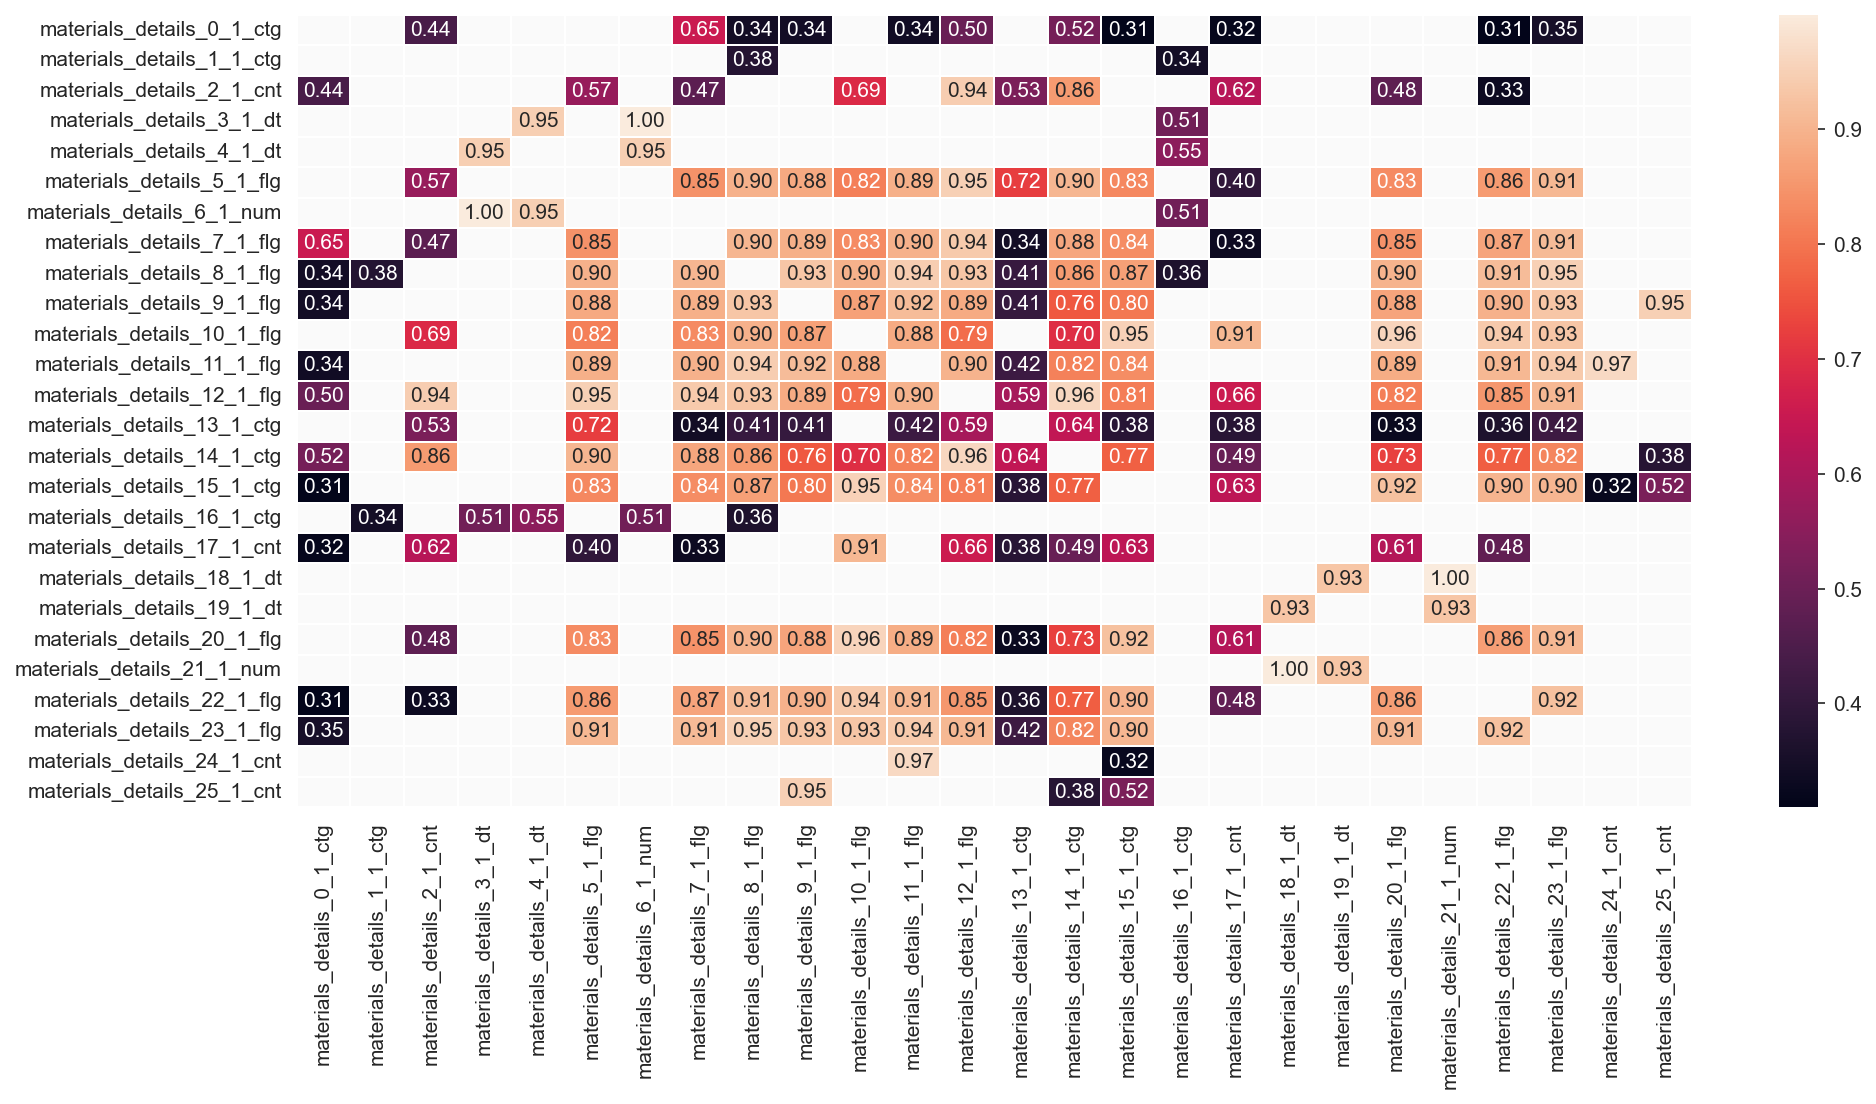

In [137]:
fig, ax = plt.subplots(figsize=(15,7), dpi=plot_dpi)
df = part_df_2.corr().abs()
sns.heatmap(df[(1 > df) & (df > 0.3)], annot=True, fmt='.2f', linewidths=0.2);